In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

In [9]:
# date range
start = "2018-06-19"
end = "2022-06-30"

In [10]:
# Tickers of assets
assets = ["XLK", "XLV","XLF","XLY","XLC","XLI","XLP","XLE","XLU","XLRE","XLB"]
assets.sort()

In [11]:
# Downloading data
data = yf.download(assets, start=start,end=end,auto_adjust=False)
data = data.loc[:,("Adj Close",slice(None))]  
# data.loc[:, ...] → selecciona todas las filas (:) y solo algunas columnas.   # ("Adj Close", slice(None)) → es una tupla para apuntar a columnas de dos niveles:
data.columns = assets  

[*********************100%***********************]  11 of 11 completed


In [12]:
# Calculating returns

Y = data[assets].pct_change().dropna()  # # filtra columnas (assets) y calcula retornos % de un periodo; quita NaN (retornos diarios si data es diaria)
Y = data.resample("M").last().pct_change().dropna() # # reagrega a fin de mes, toma último valor, calcula retornos % mensuales; quita NaN (sobrescribe Y)

display(Y.head())   # # muestra las primeras filas de Y para inspección rápida

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2018-07-31,2.8586%,-2.1603%,1.5538%,5.1147%,7.3852%,2.0873%,3.9588%,1.0394%,1.5974%,6.5540%,1.8024%
2018-08-31,-0.7701%,1.4858%,-3.4751%,1.3596%,0.2340%,6.5990%,0.3921%,2.4206%,1.2881%,4.3293%,5.1047%
2018-09-30,-1.7954%,-0.0963%,2.4460%,-2.2155%,2.1773%,-0.0193%,0.9872%,-2.6461%,-0.6484%,2.9542%,0.5304%
2018-10-31,-9.1835%,-6.0408%,-11.3282%,-4.7136%,-10.8673%,-8.0048%,2.0026%,-1.5946%,1.9753%,-6.7788%,-10.1007%
2018-11-30,3.8016%,-2.2372%,-1.5634%,2.6256%,3.8065%,-1.9625%,2.2723%,5.4845%,3.5388%,8.0835%,2.4768%


In [14]:
!pip install riskfolio-lib

In [15]:
import riskfolio as rp

In [16]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

In [17]:
# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

In [18]:
port.alpha = 0.05
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
weights,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,32.7159%,33.5077%,0.0000%,20.2946%,13.4818%,0.0000%


In [19]:
display(w)

,weights
XLB,0.0000%
XLC,0.0000%
XLE,0.0000%
XLF,0.0000%
XLI,0.0000%
XLK,32.7159%
XLP,33.5077%
XLRE,0.0000%
XLU,20.2946%
XLV,13.4818%


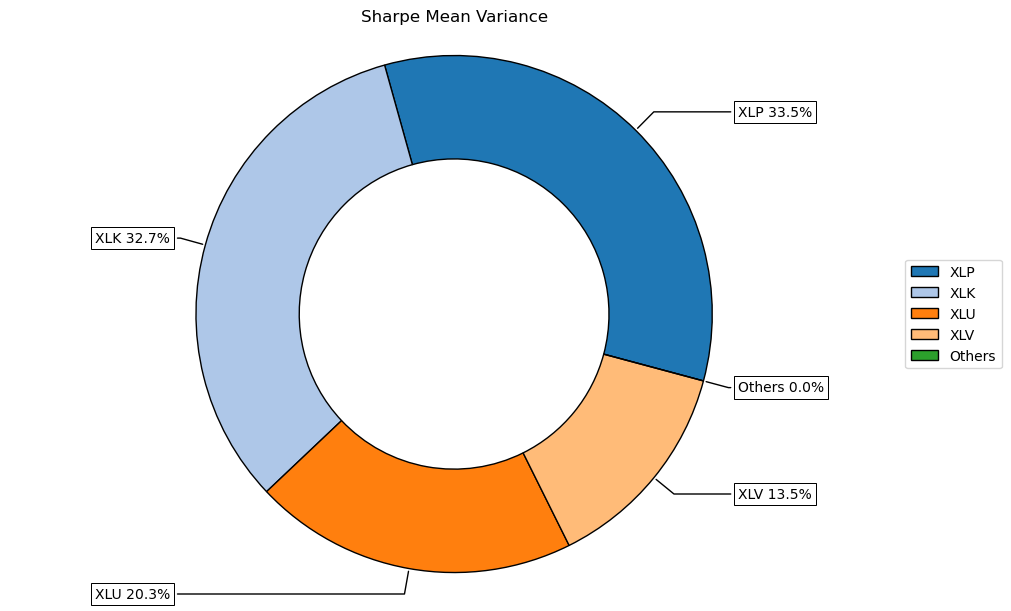

In [20]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [21]:
# Plotting portfolio composition

asset_classes = {'Assets': ['XLK', 'XLV', 'XLF', 'XLY', 'XLC', 'XLI', 'XLP', 'XLE',
          'XLU', 'XLRE', 'XLB'],
                 'Industry': ['Information Technology','Health care','Financials','Consumer Discretionary',
                              'Telecommunications Services','Industrials',
                              'Consumer Staples','Energy','Utilities','Real Estate','Materials']}

In [22]:
asset_classes = pd.DataFrame(asset_classes)
asset_classes

,Assets,Industry
0,XLK,Information Technology
1,XLV,Health care
2,XLF,Financials
3,XLY,Consumer Discretionary
4,XLC,Telecommunications Services
5,XLI,Industrials
6,XLP,Consumer Staples
7,XLE,Energy
8,XLU,Utilities
9,XLRE,Real Estate


In [23]:
asset_classes = asset_classes.sort_values(by=['Assets'])
asset_classes

,Assets,Industry
10,XLB,Materials
4,XLC,Telecommunications Services
7,XLE,Energy
2,XLF,Financials
5,XLI,Industrials
0,XLK,Information Technology
6,XLP,Consumer Staples
9,XLRE,Real Estate
8,XLU,Utilities
1,XLV,Health care


In [24]:
views = {'Disabled': [False, False, False, False],
         'Type': ['Classes', 'Classes', 'Classes','Classes'],
         'Set': ['Industry', 'Industry', 'Industry','Industry'],
         'Position': ['Health care', 'Consumer Staples', 'Utilities','Information Technology'],
         'Sign': ['>=', '>=', '>=','<='],
         'Weight': [0.11, 0.11, 0.12, 0.07], # Annual terms
         'Type Relative': ['', '', '', ''],
         'Relative Set': ['', '', '', ''],
         'Relative': ['', '', '', '']}

In [25]:
views = pd.DataFrame(views)
display(views)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative
0,False,Classes,Industry,Health care,>=,11.0000%,,,
1,False,Classes,Industry,Consumer Staples,>=,11.0000%,,,
2,False,Classes,Industry,Utilities,>=,12.0000%,,,
3,False,Classes,Industry,Information Technology,<=,7.0000%,,,


In [26]:
# Ingresando el P y Q

P, Q = rp.assets_views(views, asset_classes)

display(pd.DataFrame(P.T))
display(pd.DataFrame(Q))

,0,1,2,3
0,0.0000%,0.0000%,0.0000%,0.0000%
1,0.0000%,0.0000%,0.0000%,0.0000%
2,0.0000%,0.0000%,0.0000%,0.0000%
3,0.0000%,0.0000%,0.0000%,0.0000%
4,0.0000%,0.0000%,0.0000%,0.0000%
5,0.0000%,0.0000%,0.0000%,100.0000%
6,0.0000%,100.0000%,0.0000%,0.0000%
7,0.0000%,0.0000%,0.0000%,0.0000%
8,0.0000%,0.0000%,100.0000%,0.0000%
9,100.0000%,0.0000%,0.0000%,0.0000%


,0
0,11.0000%
1,11.0000%
2,12.0000%
3,7.0000%


In [27]:
# Estimate Black Litterman inputs:

port.blacklitterman_stats(P, Q/12, rf=rf, w=w, delta=None, eq=True)

In [28]:
# Estimate optimal portfolio:

model='BL'# Black Litterman
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios

w_bl = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_bl.T)

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
weights,0.0011%,0.0013%,0.0004%,0.0007%,0.0010%,13.8373%,42.9354%,0.0018%,29.1992%,14.0202%,0.0016%


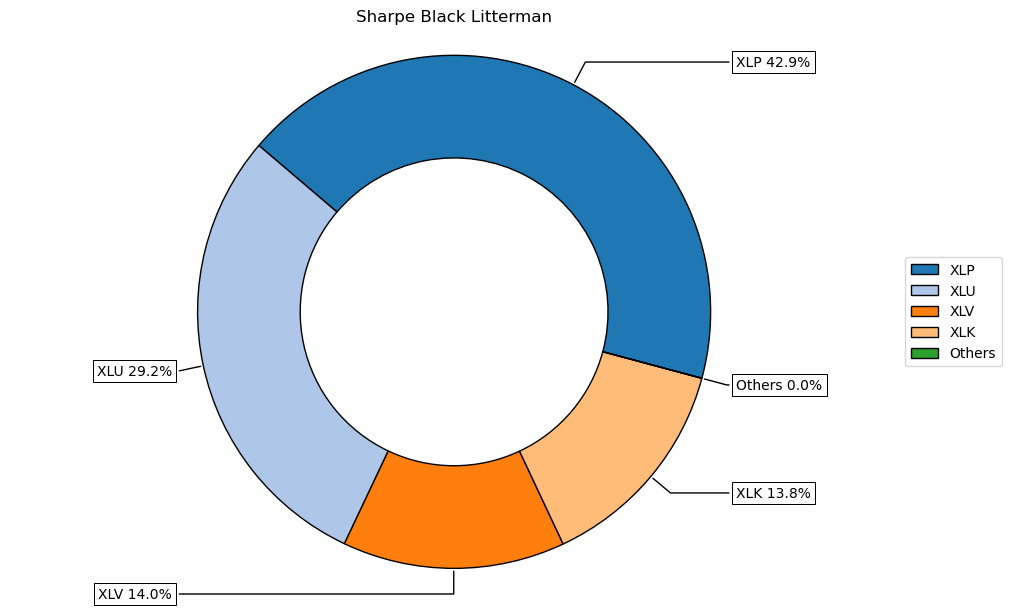

In [29]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_bl, title='Sharpe Black Litterman', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

In [30]:
# Calculate efficient frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,61.0940%,0.0000%,23.9354%,14.9707%,0.0000%
1,0.0000%,1.0738%,0.0000%,0.0000%,0.0000%,8.7099%,47.3923%,0.0001%,27.7952%,15.0285%,0.0000%
2,0.3410%,0.0003%,0.0002%,0.0003%,0.3950%,13.7474%,42.3199%,0.1885%,29.2025%,13.6708%,0.1341%
3,1.7857%,0.0001%,0.0001%,0.0001%,1.8444%,13.3539%,39.8425%,1.0731%,29.1577%,12.2395%,0.7029%
4,3.1377%,0.0000%,0.0000%,0.0000%,3.2416%,12.9846%,37.4992%,1.8868%,29.1251%,10.8898%,1.2351%


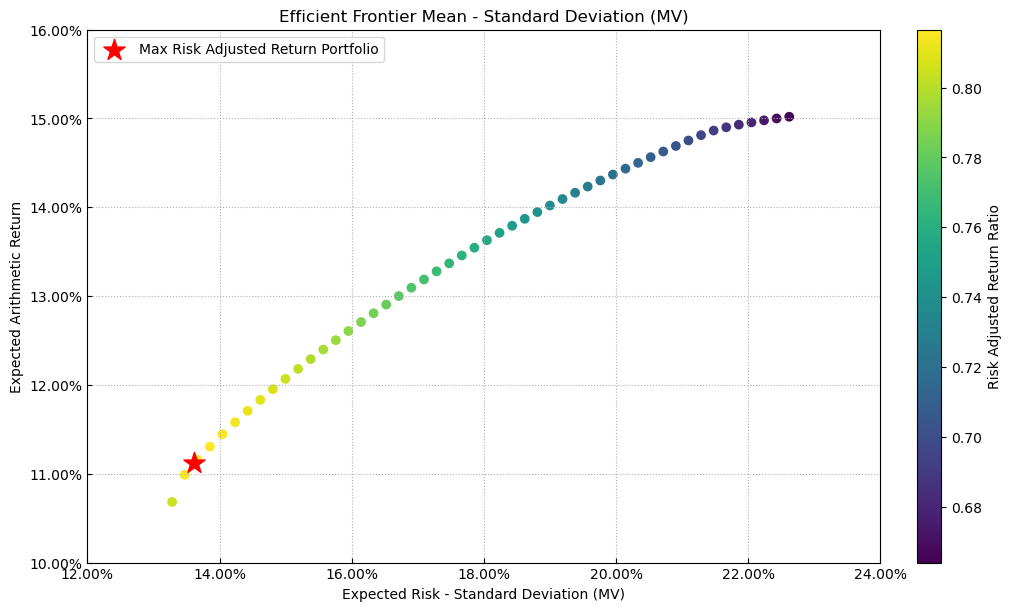

In [31]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu_bl # Expected returns of Black Litterman model
cov = port.cov_bl # Covariance matrix of Black Litterman model
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_bl, label=label,
                      marker='*', s=16, c='r', height=6, width=10, t_factor=12,ax=None)

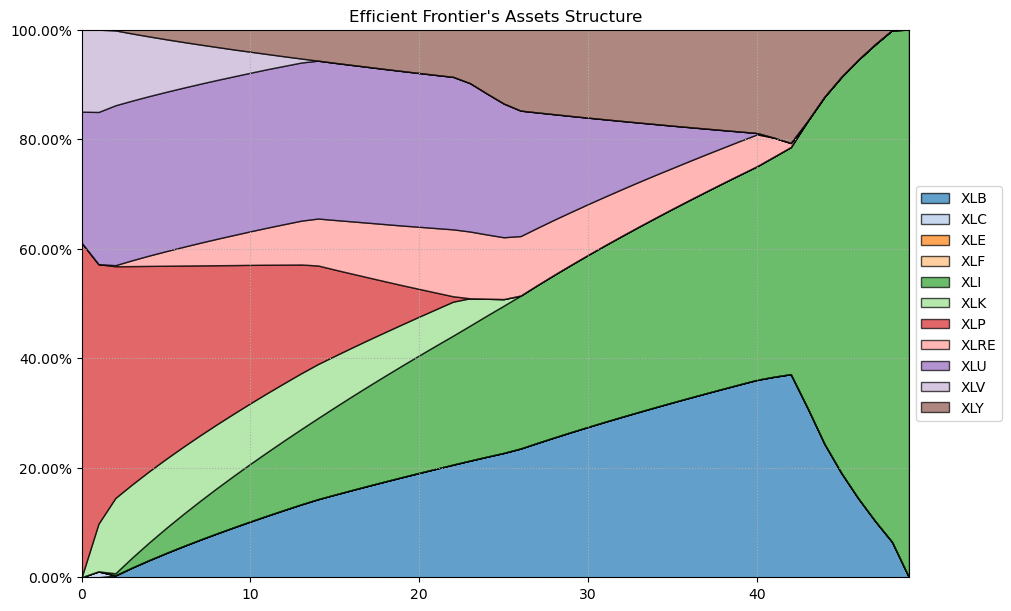

In [32]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)